# Применение метода метаобучения нейросетевых моделей в CLI

## 1. Подключение библиотек и инициализация вспомогательных функций и переменных

In [ ]:
# Импорт всех необходимых библиотек для работы нейросетевого классификатора на основе метаобучения

from openhsl.hsi import HSImage
from openhsl.hs_mask import HSMask

# В этом месте необходимо выбрать какую модель вы хотите импортировать для демонстрации
from openhsl.models.m1dcnn import M1DCNN
from openhsl.models.nm3dcnn import NM3DCNN

from openhsl.models.utils import get_mean_weights
from openhsl.utils import draw_fit_plots, unite_hsi_and_mask

from matplotlib import pyplot as plt
from collections import OrderedDict
from sklearn.metrics import classification_report, accuracy_score, f1_score, balanced_accuracy_score
from typing import Tuple

import numpy as np

import torch

In [ ]:
# Загрузка набора данных для работы нейросети
def get_dataset(ds_name) -> Tuple[HSImage, HSMask]:
    """
    Returns hsi and it's ground truth mask pair
    """
    
    PATH_TO_DATA = './data_meta'
    DIR_HSI = 'cube_r_400_1300'
    DIR_MASKS = 'masks_r_400_1300'
    
    hsi = HSImage()
    gt = HSMask()
    
    hsi_name = f"{PATH_TO_DATA}/{DIR_HSI}/cube_{ds_name}.mat"
    gt_name = f"{PATH_TO_DATA}/{DIR_MASKS}/mask_{ds_name}.npy"
    
    hsi.load(hsi_name, key="image")
    gt.load(gt_name)
    
    return hsi, gt

# Обучение выбранной модели на выбранных данных
# По окончанию возвращает набор весов и результаты обучения
# В виде значений функции потери и точности на обучающей
# И валидайионной выборках
def train_model(model, 
                ds_names, 
                fit_params,
                weights=None) -> OrderedDict:
    
    """
    Returns weights after train model
    """

    hsis = []
    masks = []
    
    for ds_name in ds_names:
        hsi, gt = get_dataset(ds_name)
        hsis.append(hsi.data)
        masks.append(gt.get_2d())
    
    if len(ds_names) > 1:
        X_train, y_train = unite_hsi_and_mask(hsis, masks)
    elif len(ds_names) == 1:
        X_train, y_train = get_dataset(ds_names[0])
    
    nn = model(n_classes=y_train.n_classes,
               n_bands=X_train.data.shape[-1],  # or hsi.data.shape[-1]
               device='cuda')
    if weights:
        nn.model.load_state_dict(weights)
    
    nn.fit(X_train, 
           y_train.get_2d(), 
           fit_params)
    
    weights = nn.model.state_dict()
    
    train_params = dict()
    train_params['train_loss'] = nn.train_loss
    train_params['val_loss'] = nn.val_loss
    train_params['train_accs'] = nn.train_accs
    train_params['val_accs'] = nn.val_accs
    
    return weights, train_params, nn

In [ ]:
# Весь набор данных
all_data = [
    'r1',
    'r2',
    'r3',
    'r4',
    'r5',
    'r6',
    'r7',
    'r8',
    'r9',
    'r10',
    'valid_1r',
    'valid_3r'
]

In [4]:
# Данные для предварительного обучения нейросети
large_scale_ds_names = [
    'r1',
    'r2',
    'r3',
    'r4',
    'r5'
]

# Малый набор данных для адаптации нейросети
# Методами трансферного и метаобучения
wi_ds_names = [
    'r6',
    'r7',
    'r8',
    'r10' 
]

# Валидационные изображения для финального этапа
fs_ds_names = [
    'valid_1r',
    'valid_3r'
]

fs_ds_hsi = []
fs_ds_masks = []

for fs_ds_name in fs_ds_names:
    hsi, gt = get_dataset(fs_ds_name)
    fs_ds_hsi.append(hsi.data)
    fs_ds_masks.append(gt.get_2d())


### Выбор модели

In [4]:
curr_model = NM3DCNN

## 2. Демонстрация наборов данных

In [7]:
plt.rcParams["figure.figsize"] = (15,7)

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!


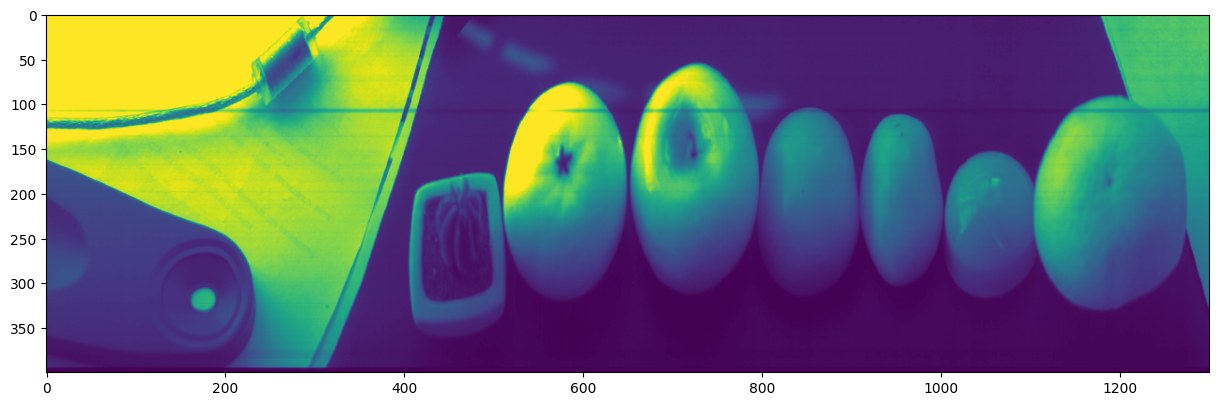

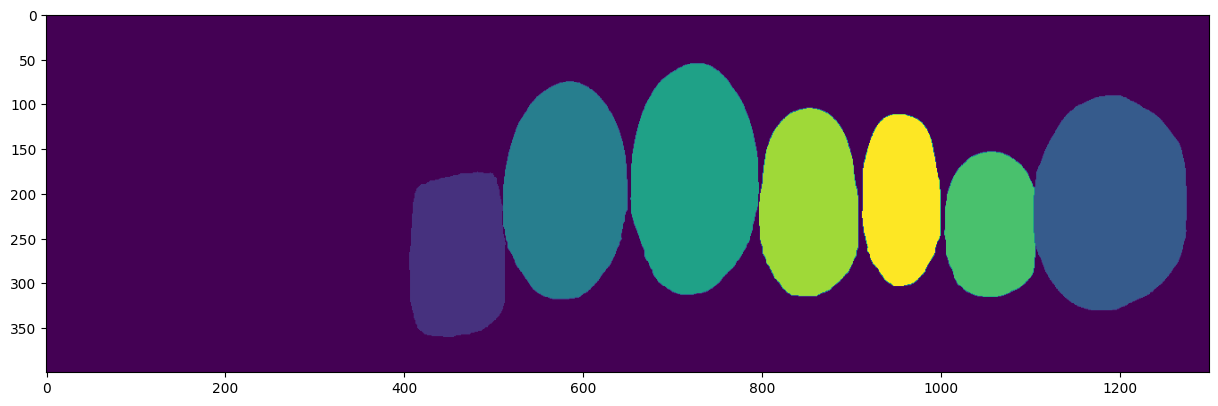

In [8]:
hsi_demo, gt_demo = get_dataset('r1') 
plt.imshow(hsi_demo[100])
plt.show()
plt.imshow(gt_demo.get_2d())
plt.show()

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!


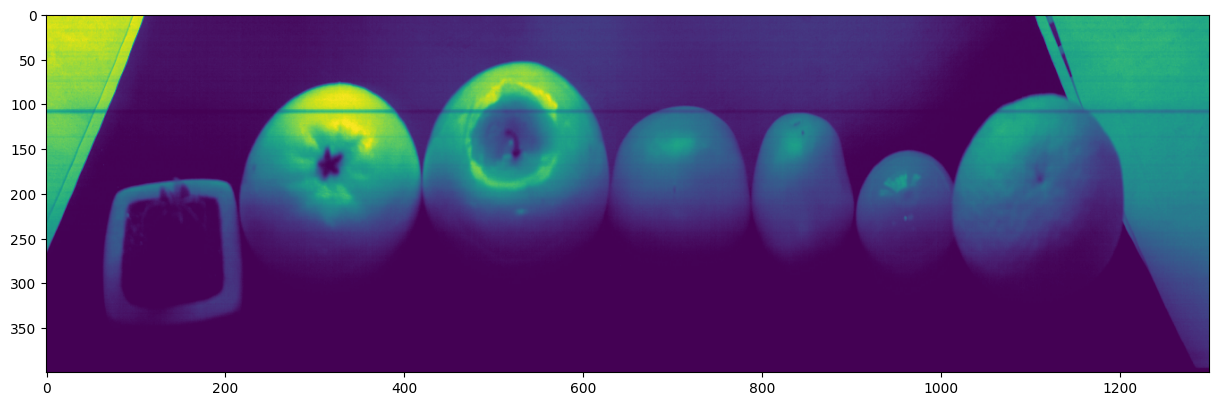

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!


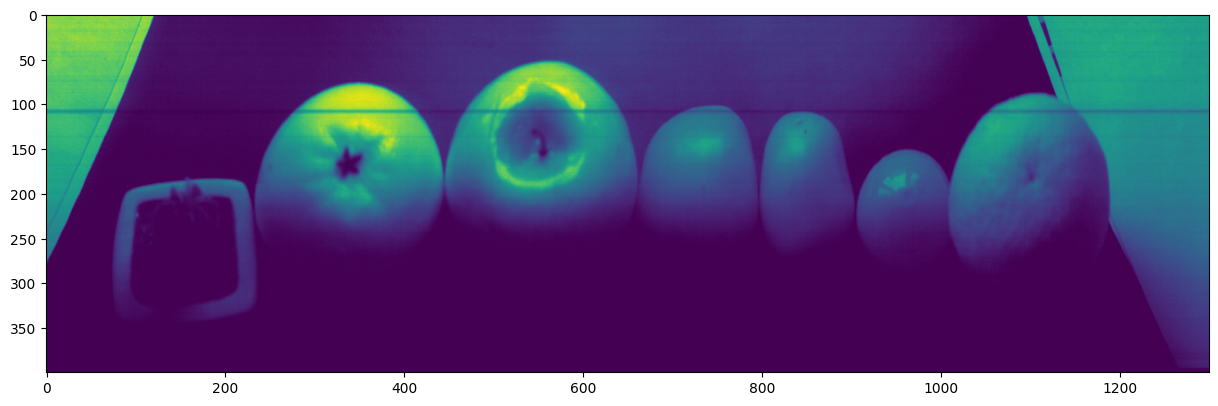

In [9]:
hsi_demo, gt_demo = get_dataset('r8') 
plt.imshow(hsi_demo[100])
plt.show()
hsi_demo, gt_demo = get_dataset('r9') 
plt.imshow(hsi_demo[100])
plt.show()

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!


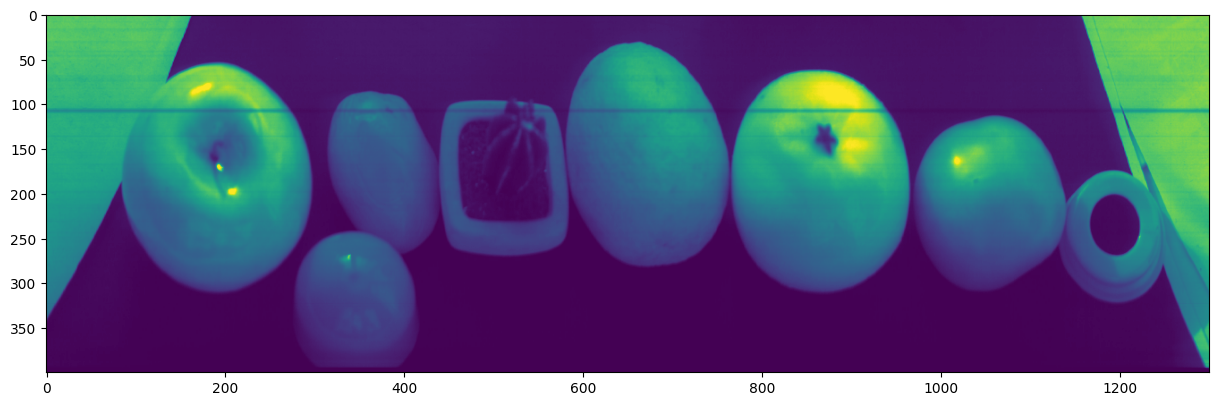

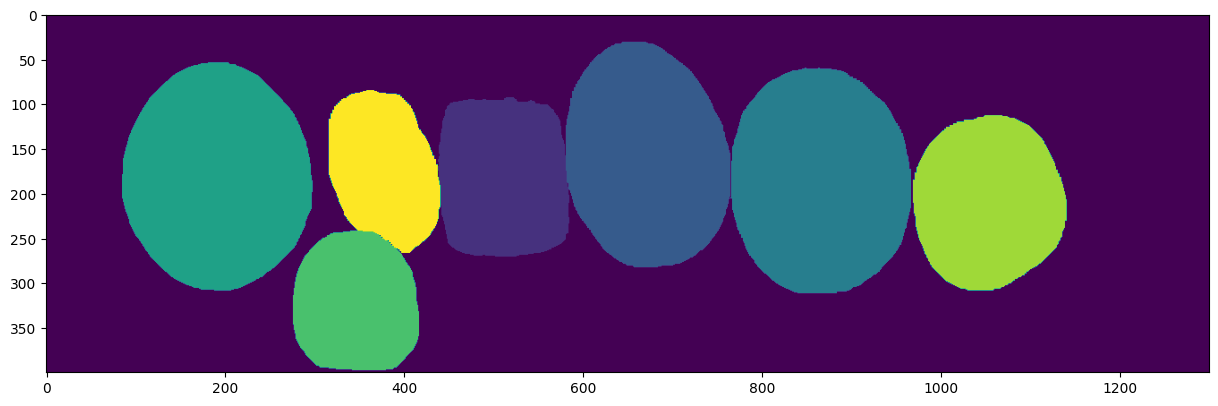

In [10]:
hsi_demo, gt_demo = get_dataset('valid_1r') 
plt.imshow(hsi_demo[100])
plt.show()
plt.imshow(gt_demo.get_2d())
plt.show()

## 3. Предварительное обучение нейросетевой модели на большом наборе данных

In [ ]:
optimizer_params = {
    "learning_rate": 0.01,
    "weight_decay": 0
}

scheduler_params = {
    "step_size": 2,
    "gamma": 0.5
}

fit_params_ls = {
    "epochs": 30,
    "train_sample_percentage": 0.95,
    "dataloader_mode": "fixed",
    "scheduler_params": scheduler_params,
    "optimizer_params": optimizer_params
}

ls_weights, ls_tr_metrics, nn = train_model(model=curr_model,
                                            ds_names=large_scale_ds_names, 
                                            fit_params=fit_params_ls)

torch.save(ls_weights, "./large_scale_model/large_scale.pt")

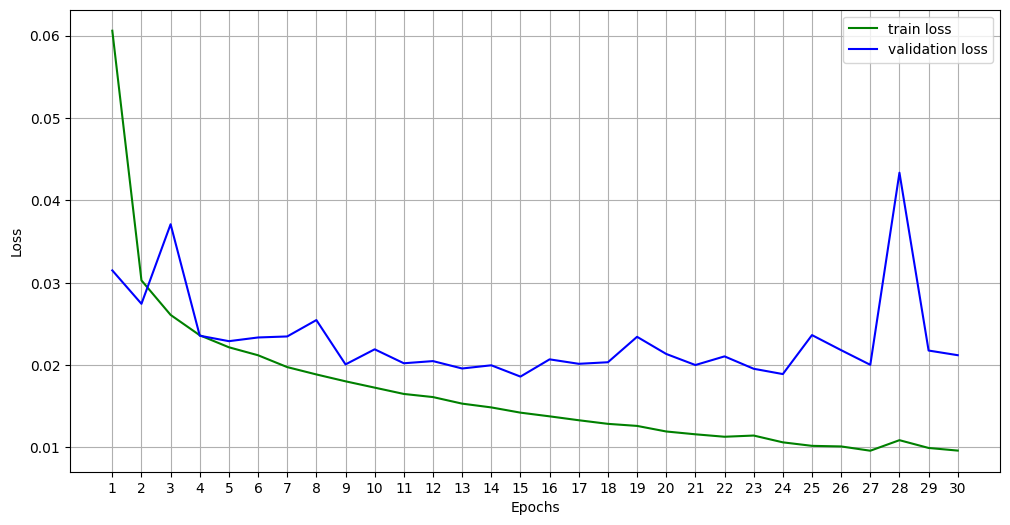

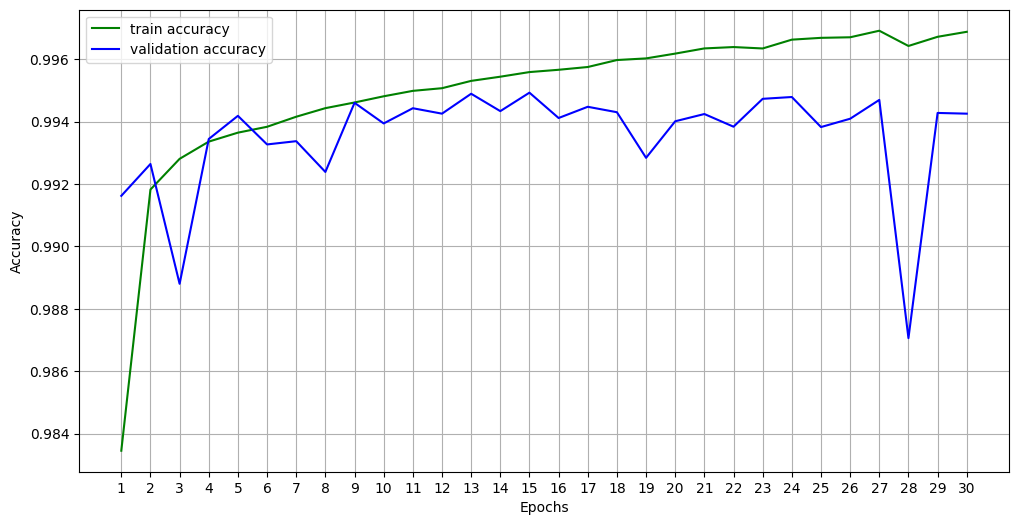

In [13]:
draw_fit_plots(nn)

### Проверка предобученной модели на валидационных данных

In [20]:
X_val, y_val = unite_hsi_and_mask(fs_ds_hsi, fs_ds_masks)

nn = curr_model(n_classes=y_val.n_classes,
                n_bands=X_val.data.shape[-1],  
                device='cuda')
nn.model.load_state_dict(ls_weights)

pred_ls = nn.predict(X_val)

pred_ls = pred_ls * (y_val.get_2d() > 0)

pred_ls = pred_ls.flatten()
gt_ls = y_val.get_2d().flatten()
    
acc = accuracy_score(pred_ls, gt_ls)
bacc = balanced_accuracy_score(pred_ls, gt_ls)
f1 = f1_score(pred_ls, gt_ls, average='weighted')
    
print(f'transf+few-shot acc: {acc}\t bal-acc: {bacc}\t f1_w: {f1}')

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Wavelengths data is empty
got 2d mask
Void data or incorrect data. Set label classes to None


Inference on the image: 25686it [01:05, 391.99it/s]                                                                    


transf+few-shot acc: 0.8705721153846154	 bal-acc: 0.7541471800225212	 f1_w: 0.8701491314417563


## 4. Трансферное обучение предварительно обученной модели

In [ ]:
ls_weights = torch.load("./large_scale_model/large_scale.pt")

optimizer_params = {
    "learning_rate": 0.01,
    "weight_decay": 0
}

scheduler_params = {
    "step_size": 5,
    "gamma": 0.5
}

fit_params_ls = {
    "epochs": 50,
    "train_sample_percentage": 0.5,
    "dataloader_mode": "fixed",
    "scheduler_params": scheduler_params,
    "optimizer_params": optimizer_params
}

tl_weights, tl_tr_metrics, nn = train_model(model=curr_model,
                                            ds_names=wi_ds_names, 
                                            fit_params=fit_params_ls,
                                            weights=ls_weights)

torch.save(tl_weights, "./transfer_learning/tf_after_ls.pt")

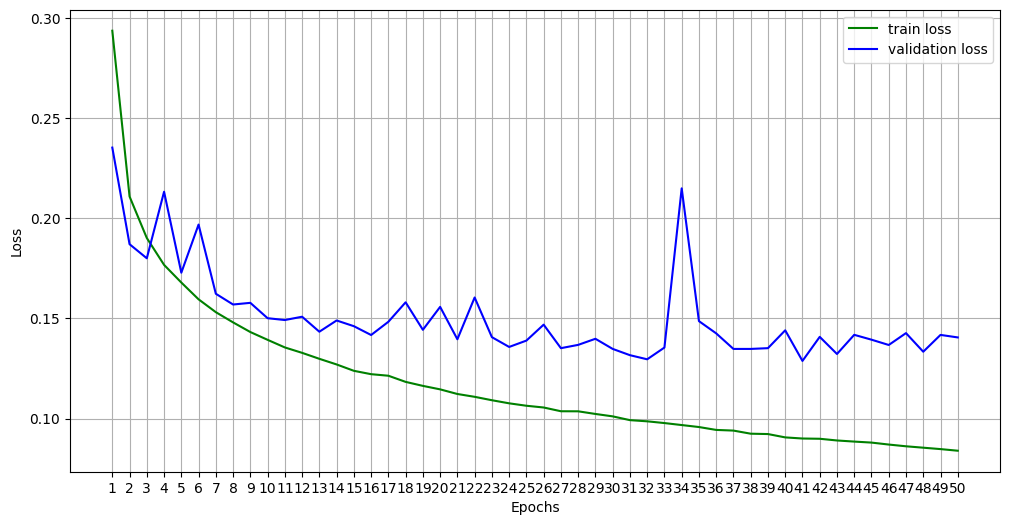

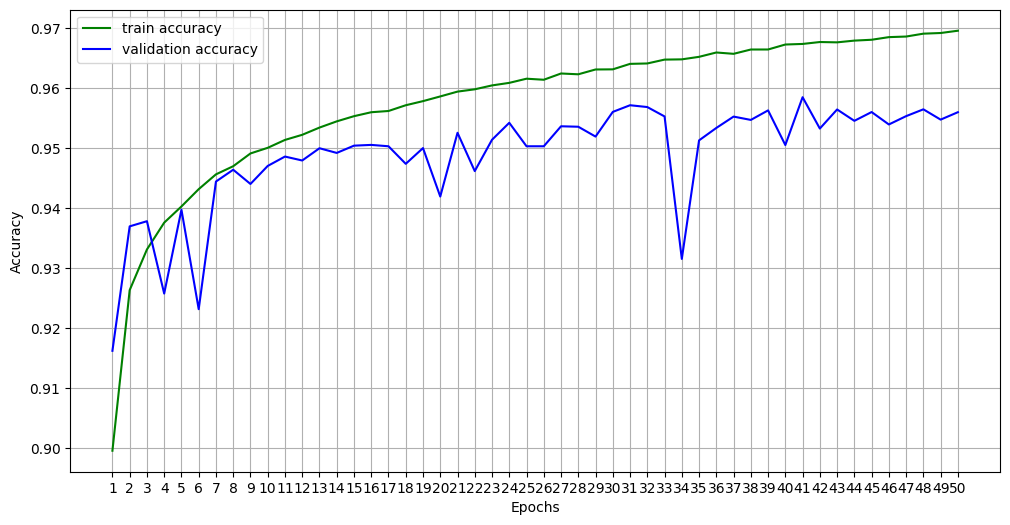

In [15]:
draw_fit_plots(nn, 'large_scale')

### Проверка трансферной модели на валидационных данных

In [16]:
X_val, y_val = unite_hsi_and_mask(fs_ds_hsi, fs_ds_masks)

nn = curr_model(n_classes=y_val.n_classes,
                n_bands=X_val.data.shape[-1],  
                device='cuda')

nn.model.load_state_dict(torch.load("./transfer_learning/tf_after_ls_nm3dcnn_final.pt"))

pred_ls = nn.predict(X_val)

pred_ls = pred_ls * (y_val.get_2d() > 0)

pred_ls = pred_ls.flatten()
gt_ls = y_val.get_2d().flatten()
    
acc = accuracy_score(pred_ls, gt_ls)
bacc = balanced_accuracy_score(pred_ls, gt_ls)
f1 = f1_score(pred_ls, gt_ls, average='weighted')
    
print(f'transfer-learning acc: {acc}\t bal-acc: {bacc}\t f1_w: {f1}')

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Wavelengths data is empty
got 2d mask
Void data or incorrect data. Set label classes to None


Inference on the image: 25686it [00:45, 568.23it/s]                                                                    


transfer-learning acc: 0.9429528846153846	 bal-acc: 0.8397572020408134	 f1_w: 0.9445810388546034


## 5. Метаобучение предварительно обученной модели на 4 разных изображениях

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Sampling fixed with train size = 0.5 for train_val/test
Sampling fixed with train size = 0.9 for train/val
Full size: 206827
Train size: 93068
Val size: 10344


Train loop: 100%|█| 30/30 [13:03<00:00, 26.10s/it, train_acc=0.943, val_acc=0.938, train_loss=0.168, val_loss=0.183, lr


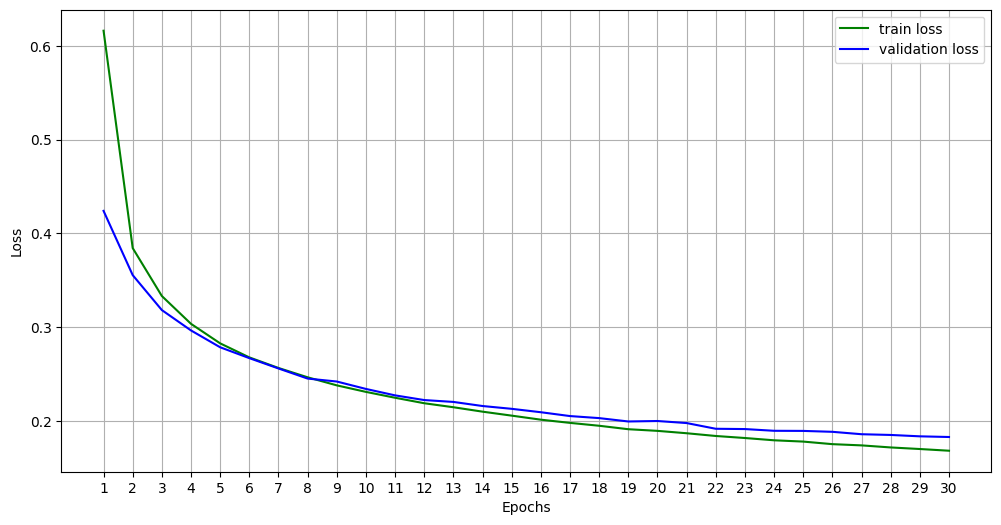

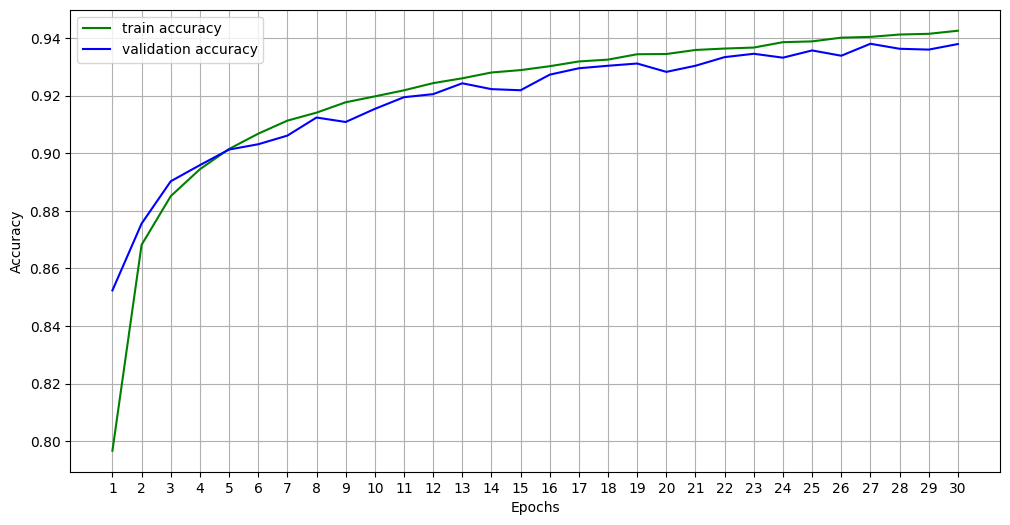

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Sampling fixed with train size = 0.5 for train_val/test
Sampling fixed with train size = 0.9 for train/val
Full size: 204068
Train size: 91825
Val size: 10207


Train loop: 100%|█| 30/30 [15:00<00:00, 30.00s/it, train_acc=0.971, val_acc=0.966, train_loss=0.089, val_loss=0.116, lr


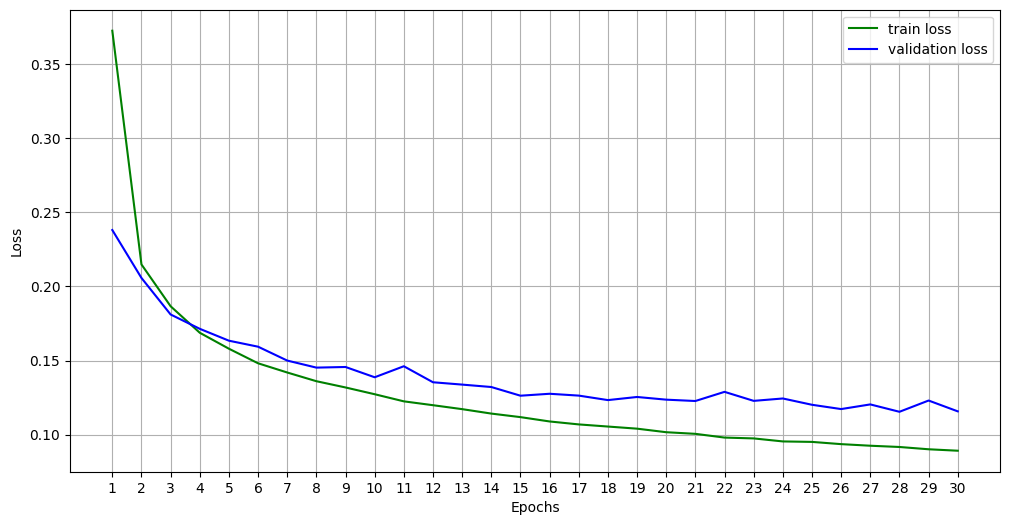

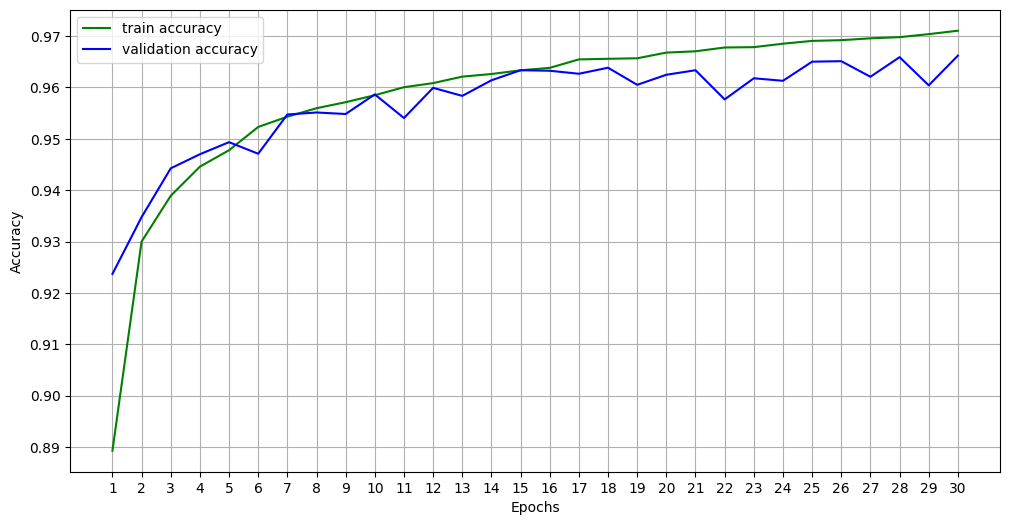

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Sampling fixed with train size = 0.5 for train_val/test
Sampling fixed with train size = 0.9 for train/val
Full size: 199357
Train size: 89706
Val size: 9971


Train loop: 100%|█| 30/30 [15:25<00:00, 30.86s/it, train_acc=0.985, val_acc=0.981, train_loss=0.051, val_loss=0.068, lr


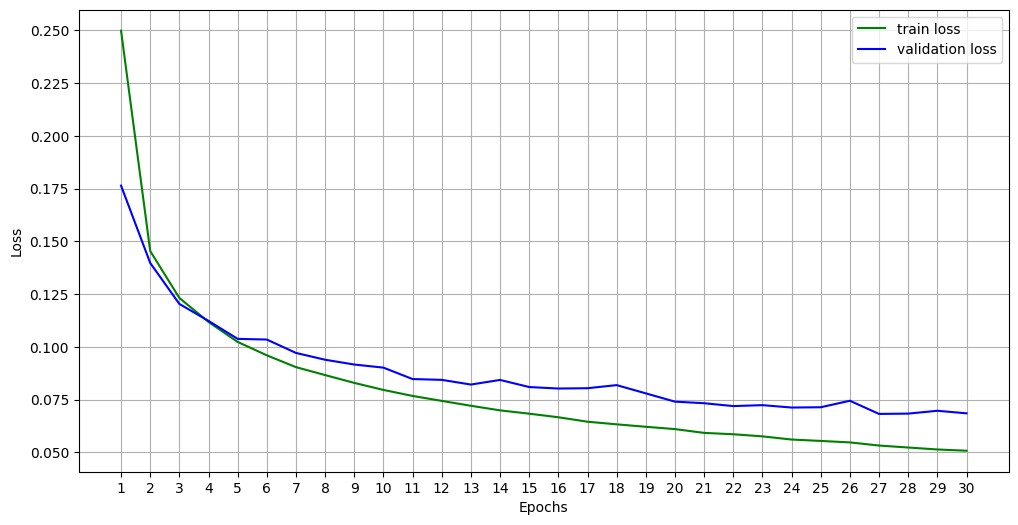

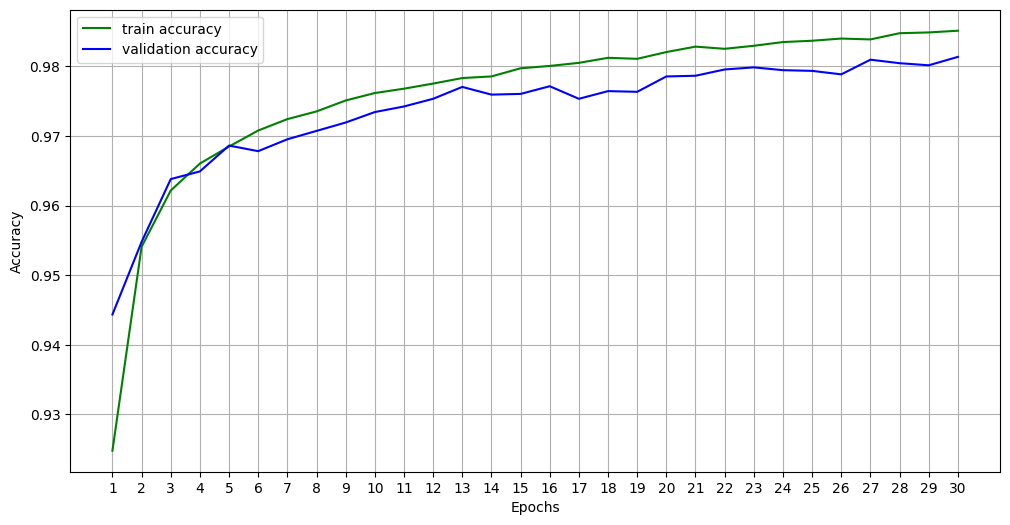

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Sampling fixed with train size = 0.5 for train_val/test
Sampling fixed with train size = 0.9 for train/val
Full size: 182148
Train size: 81962
Val size: 9110


Train loop: 100%|█| 30/30 [14:05<00:00, 28.19s/it, train_acc=0.965, val_acc=0.957, train_loss=0.103, val_loss=0.135, lr


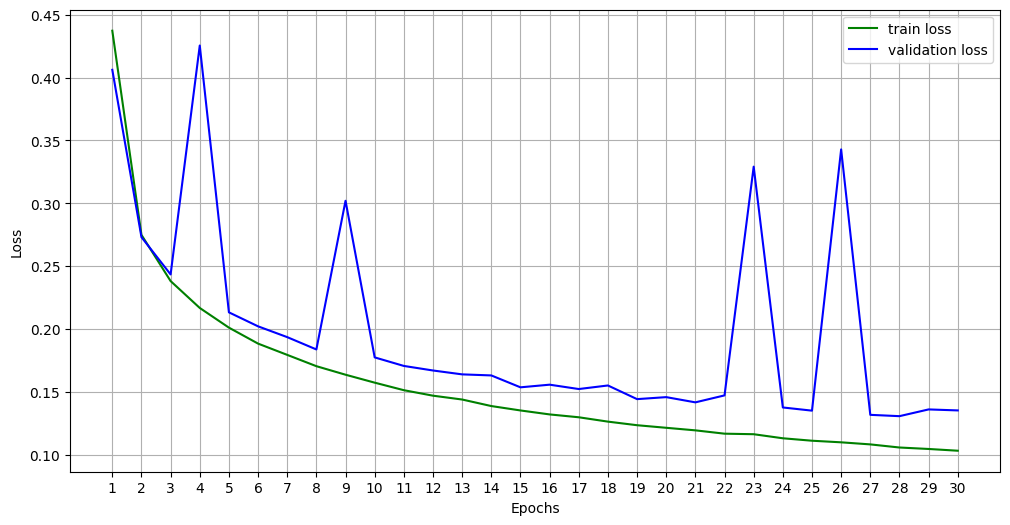

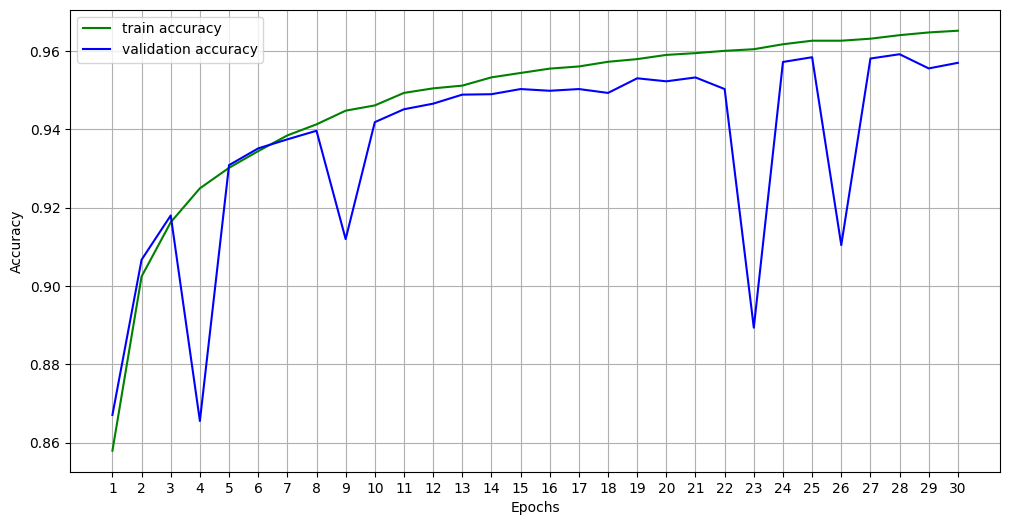

In [18]:
wi_list = []
wi_tr_metrics_list = []

ls_weights = torch.load("./large_scale_model/large_scale.pt")

for wi_ds_name in wi_ds_names:
    optimizer_params = {
        "learning_rate": 0.001, #на порядок меньше, чем стартовый в LS
        "weight_decay": 0
    }

    scheduler_params = {
        "step_size": 5,
        "gamma": 0.5
    }

    fit_params_wi = {
        "epochs": 30,
        "train_sample_percentage": 0.5,
        "dataloader_mode": "fixed",
        "scheduler_params": scheduler_params,
        "optimizer_params": optimizer_params
    }

    wi_weights, wi_tr_metrics, nn = train_model(model=curr_model,
                                                ds_names=[wi_ds_name], 
                                                fit_params=fit_params_wi,
                                                weights=ls_weights)
    wi_list.append(wi_weights)
    wi_tr_metrics_list.append(wi_tr_metrics)

    draw_fit_plots(nn)

    torch.save(wi_weights, "./wi_weights/"+wi_ds_name+"_wi.pt")
    
    # добавить валидацию на остальных данных

wi_mean_weight = get_mean_weights(wi_list)

In [19]:
X_val, y_val = unite_hsi_and_mask(fs_ds_hsi, fs_ds_masks)

nn = curr_model(n_classes=y_val.n_classes,
                n_bands=X_val.data.shape[-1],  
                device='cuda')

for num, wi_w in enumerate(wi_list):
    nn.model.load_state_dict(wi_w)

    pred_wi = nn.predict(X_val)

    pred_wi = pred_wi * (y_val.get_2d() > 0)
    
    pr_wi = pred_wi.flatten()
    gt_wi = y_val.get_2d().flatten()
    
    acc = accuracy_score(pr_wi, gt_wi)
    bacc = balanced_accuracy_score(pr_wi, gt_wi)
    f1 = f1_score(pr_wi, gt_wi, average='weighted')
    
    print(f'w_{num + 1} acc: {acc}\t bal-acc: {bacc}\t f1_w: {f1}')

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Wavelengths data is empty
got 2d mask
Void data or incorrect data. Set label classes to None


Inference on the image: 25686it [00:52, 484.99it/s]                                                                    


w_1 acc: 0.9141442307692308	 bal-acc: 0.7647550845836943	 f1_w: 0.9234099311107873


Inference on the image: 25686it [00:52, 491.35it/s]                                                                    


w_2 acc: 0.9216211538461538	 bal-acc: 0.7849794447963115	 f1_w: 0.9214650728793932


Inference on the image: 25686it [00:54, 468.84it/s]                                                                    


w_3 acc: 0.9160336538461539	 bal-acc: 0.7966822210567475	 f1_w: 0.9210282272298651


Inference on the image: 25686it [00:58, 442.45it/s]                                                                    


w_4 acc: 0.921075	 bal-acc: 0.8016654019448375	 f1_w: 0.921281236572582


## 6. Адаптация нейросетевых моделей к новым наборам данных малого размера

### Адаптация методом трансферного обучения

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Wavelengths data is empty
got 2d mask
Void data or incorrect data. Set label classes to None
Sampling fixed with train size = 0.01 for train_val/test
Sampling fixed with train size = 0.9 for train/val
Full size: 402390
Train size: 3617
Val size: 404


Train loop: 100%|█| 100/100 [02:04<00:00,  1.24s/it, train_acc=0.976, val_acc=0.950, train_loss=0.067, val_loss=0.125, 


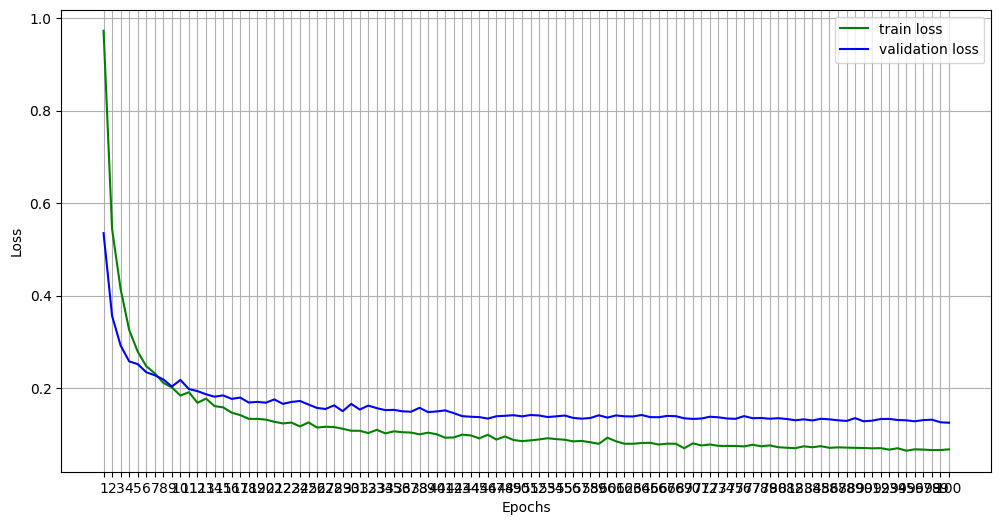

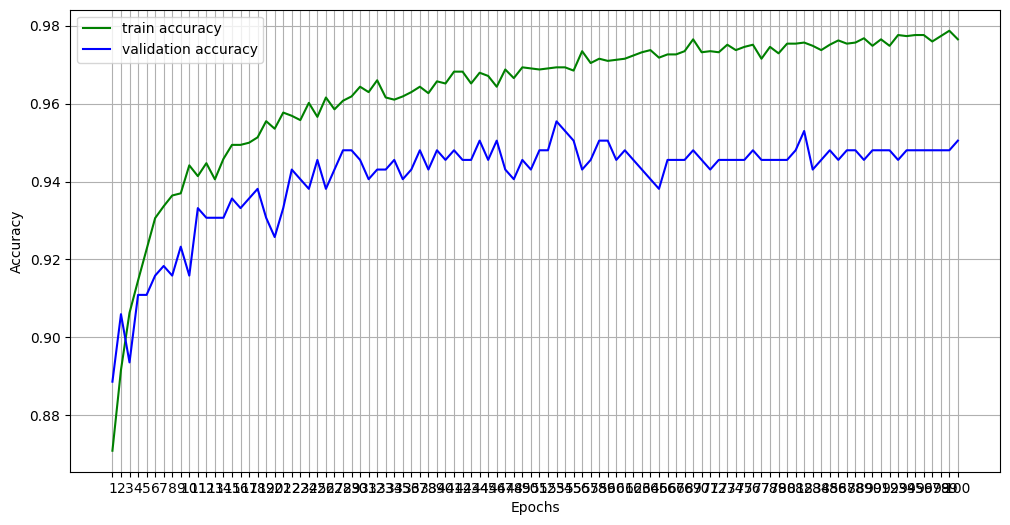

Inference on the image: 25686it [00:56, 456.89it/s]                                                                    


In [24]:
X_train_fs, y_train_fs = unite_hsi_and_mask(fs_ds_hsi, fs_ds_masks)

nn_tl_fs = curr_model(n_classes=y_train_fs.n_classes,
                      n_bands=X_train_fs.data.shape[-1],  
                      device='cuda')

tl_weights = torch.load("./transfer_learning/tf_after_ls_nm3dcnn_final.pt", weights_only=True)
nn_tl_fs.model.load_state_dict(tl_weights)

optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}

scheduler_params = {
    "step_size": 10,
    "gamma": 0.2
}

fit_params_tl_fs = {
    "epochs": 100,
    "train_sample_percentage": 0.01,
    "dataloader_mode": "fixed",
    "scheduler_params": scheduler_params,
    "optimizer_params": optimizer_params
}

nn_tl_fs.fit(X_train_fs,
             y_train_fs,
             fit_params=fit_params_tl_fs)

draw_fit_plots(nn_tl_fs)

pred_tl_fs = nn_tl_fs.predict(X_train_fs)

### Адаптация методом метаобучения

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!
Wavelengths data is empty
got 2d mask
Void data or incorrect data. Set label classes to None
Sampling fixed with train size = 0.01 for train_val/test
Sampling fixed with train size = 0.9 for train/val
Full size: 402390
Train size: 3617
Val size: 404


Train loop: 100%|█| 100/100 [02:00<00:00,  1.21s/it, train_acc=0.988, val_acc=0.968, train_loss=0.048, val_loss=0.122, 


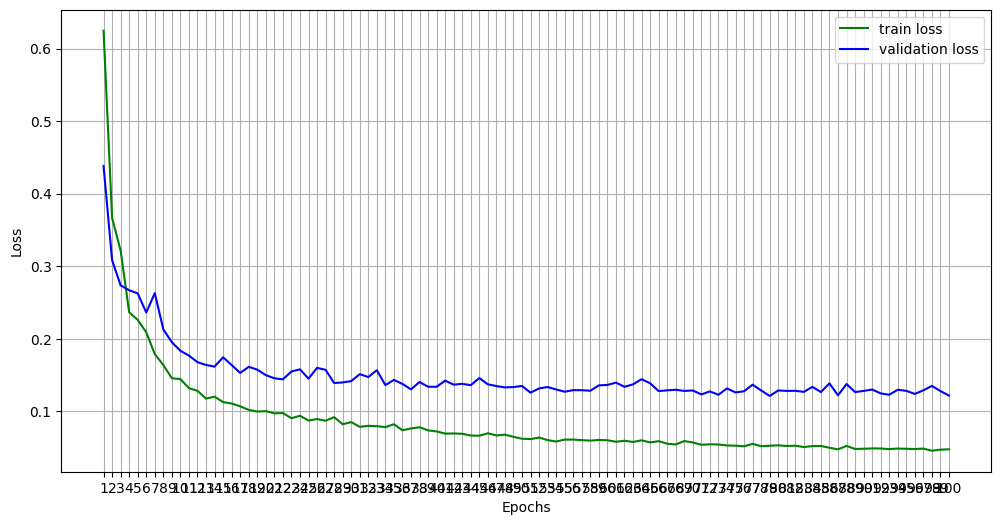

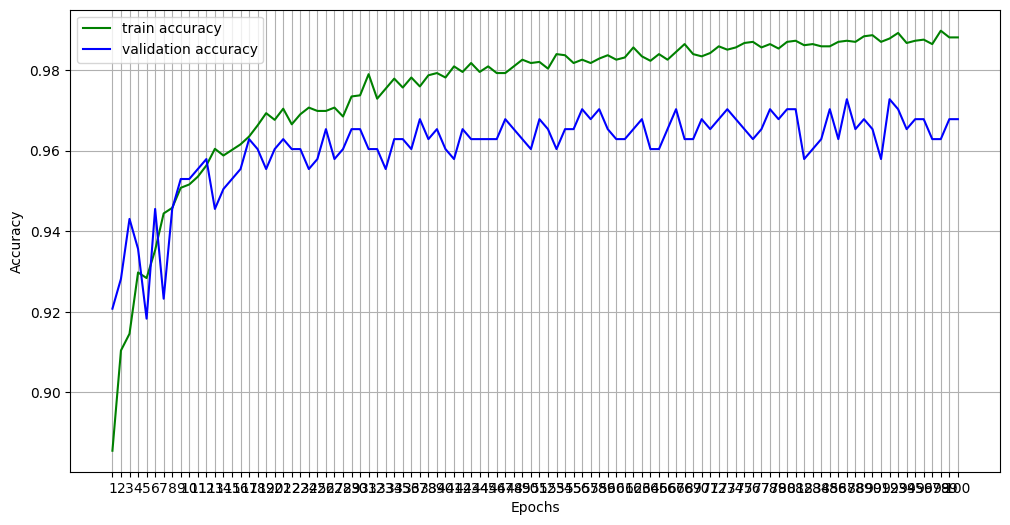

Inference on the image: 25686it [00:55, 460.23it/s]                                                                    


In [25]:
X_train_fs, y_train_fs = unite_hsi_and_mask(fs_ds_hsi, fs_ds_masks)

nn_ml_fs = curr_model(n_classes=y_train_fs.n_classes,
                      n_bands=X_train_fs.data.shape[-1],  
                      device='cuda')

wi_list = []
for wi_ds_name in wi_ds_names:    
    wi_list.append(torch.load("./wi_weights/"+wi_ds_name+"_nm3dcnn_final.pt", weights_only=True))    
wi_mean_weight = get_mean_weights(wi_list)

nn_ml_fs.model.load_state_dict(wi_mean_weight)

optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}

scheduler_params = {
    "step_size": 10,
    "gamma": 0.2
}

fit_params_ml_fs = {
    "epochs": 100,
    "train_sample_percentage": 0.01,
    "dataloader_mode": "fixed",
    "scheduler_params": scheduler_params,
    "optimizer_params": optimizer_params
}

nn_ml_fs.fit(X_train_fs,
             y_train_fs,
             fit_params=fit_params_ml_fs)

draw_fit_plots(nn_ml_fs)

pred_ml_fs = nn_ml_fs.predict(X_train_fs)

## 7. Результаты доменнной адаптации к новым данным

#### Результаты трансферного обучения

In [26]:
pred_tl_fs = pred_tl_fs * (y_train_fs.get_2d() > 0)

pr_tl_fs = pred_tl_fs.flatten()
gt_tl_fs = y_train_fs.get_2d().flatten()
    
acc = accuracy_score(pr_tl_fs, gt_tl_fs)
bacc = balanced_accuracy_score(pr_tl_fs, gt_tl_fs)
f1 = f1_score(pr_tl_fs, gt_tl_fs, average='weighted')
    
print(f'transf+few-shot acc: {acc}\t bal-acc: {bacc}\t f1_w: {f1}')


transf+few-shot acc: 0.983989423076923	 bal-acc: 0.9558350231705224	 f1_w: 0.9839669454543988


#### Результаты метаобучения

In [27]:
pred_ml_fs = pred_ml_fs * (y_train_fs.get_2d() > 0)

pr_ml_fs = pred_ml_fs.flatten()
gt_ml_fs = y_train_fs.get_2d().flatten()
    
acc = accuracy_score(pr_ml_fs, gt_ml_fs)
bacc = balanced_accuracy_score(pr_ml_fs, gt_ml_fs)
f1 = f1_score(pr_ml_fs, gt_ml_fs, average='weighted')
    
print(f'meta+few-shot acc: {acc}\t bal-acc: {bacc}\t f1_w: {f1}')

meta+few-shot acc: 0.9865509615384616	 bal-acc: 0.9635368403478215	 f1_w: 0.9865066224813098
